# AstroPrism Tutorial: Gaussian Process Prior (Sky Model)

The sky model is represented as a Gaussian Process (GP) that captures spatial and cross-channel correlations in astronomical images. AstroPrism provides two GP models:

- **SpatialGP**: Independent GP per channel with spatial correlation ($u \sim \text{GP}(0, K)$)
- **MixtureGP**: Linear mixing of latent GPs ($s = \text{activation}(A \cdot u + c)$)

The GP hyperparameters control:
- `fluctuations`: Overall amplitude of variations
- `loglogavgslope`: Power spectrum slope (steeper = smoother)
- `flexibility`: How much the spectrum can deviate from a power law

## Environment

To run this tutorial, create a virtual environment and install AstroPrism in editable mode:

```bash
cd /path/to/astroprism

# Create and activate a virtual environment
python3 -m venv .venv
source .venv/bin/activate

# Install AstroPrism with dev dependencies
pip install -e ".[dev]"

# Register the Jupyter kernel
python -m ipykernel install --user --name=astroprism
```

Then select the **astroprism** kernel in Jupyter or VS Code.

## Imports

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import warnings
from astropy.utils.exceptions import AstropyWarning
import jax

warnings.filterwarnings('ignore', category=AstropyWarning)

## Demonstration

In [10]:
# Load Dataset
from astroprism.io import load_dataset, SingleInstrumentDataset
path = "../data/tutorial/jwst_miri_cutout/"
dataset = load_dataset(path=path, instrument="JWST_MIRI", extension="fits")
print(dataset.summary())

SingleInstrumentDataset Summary:
--------------------------------
Number of channels: 4
Channel keys: ['F1000W_full', 'F1130W_full', 'F2100W_full', 'F770W_full']
Channel shapes: [(180, 180), (180, 180), (180, 180), (180, 180)]
Pixel scales: [(3600.0, 3600.0), (3600.0, 3600.0), (3600.0, 3600.0), (3600.0, 3600.0)]



### Example 1: SpatialGP

`SpatialGP` creates independent correlated fields for each channel:

$$u_i \sim \text{GP}(0, K_i)$$

Where $K_i$ is the spatial covariance kernel for channel $i$, parameterized by a power spectrum. The output can be positive or negative (standard Gaussian).

Sampled Parameters:
flexibility: [ 0.12566231 -0.47396249 -1.55400245  1.31723552]
fluctuations: [ 0.04216289  0.50891602  1.46991681 -0.59459908]
loglogavgslope: [-0.21314687  1.4264826   0.09148313  0.17509456]


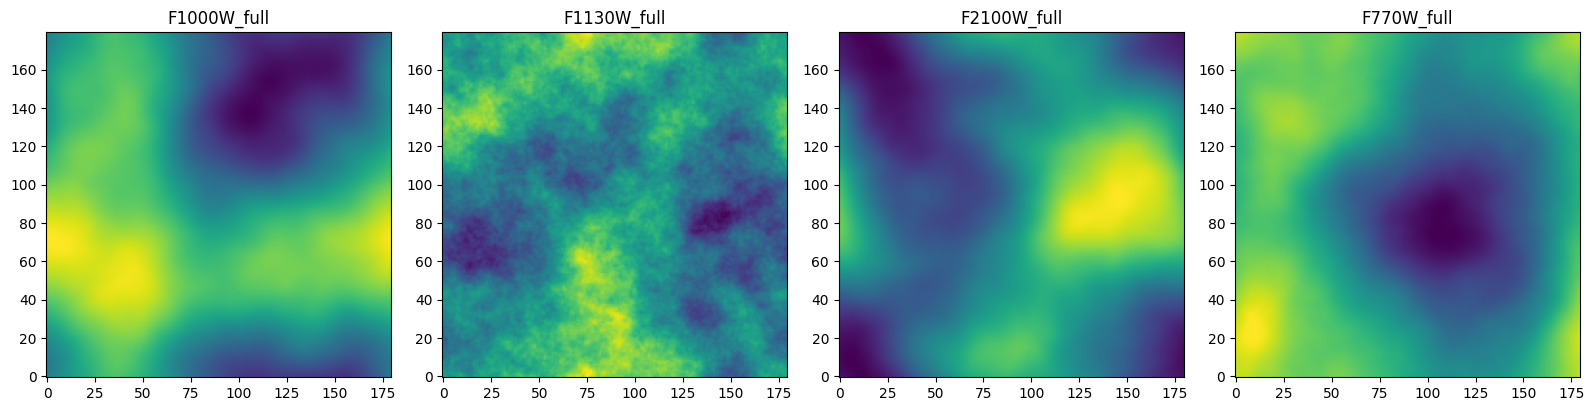

SpatialGP domain keys: ['zeromode', 'fluctuations', 'loglogavgslope', 'spectrum', 'flexibility', 'xi']


In [11]:
# Imports
from astroprism.models import SpatialGP

# SpatialGP: a multi-channel GP with spatial within-channel covariance
spatial_gp = SpatialGP(
    n_channels=len(dataset),          
    shape=dataset.shapes[0], # pick the first channel as reference for shape
    distances=dataset.pixel_scales[0] # pick the first channel as reference for pixel distances
)

# Draw random sample from SpatialGP prior
key = jax.random.PRNGKey(1234)
params = spatial_gp.init(key)
sample = spatial_gp(params)

# Print the sampled GP parameters (first 3 only)
print("Sampled Parameters:")
for name, value in list(params.items())[:3]:
    print(f"{name}: {value}")

# Plot
fig, axes = plt.subplots(1, dataset.n_channels, figsize=(4*dataset.n_channels, 4))
for i in range(dataset.n_channels):
    axes[i].imshow(sample[i], origin='lower')
    axes[i].set_title(dataset.channel_keys[i])
plt.tight_layout()
plt.show()

# Print the domain of the SpatialGP (parameters)
print("SpatialGP domain keys:", list(spatial_gp.domain.keys()))

### Example 2: MixtureGP

`MixtureGP` wraps `SpatialGP` and adds cross-channel mixing:

$$s = \text{activation}(A \cdot u + c)$$

Where:
- $u$ = latent GP fields (from `SpatialGP`)
- $A$ = mixing matrix (learned, captures cross-channel correlations)
- $c$ = offset per channel
- $\text{activation}$ = output transform (default: `exp` for positive flux)

This is the recommended model for astronomical images.

Sampled Parameters:
flexibility: [-1.15502102  1.28903635  0.94822266 -0.17327891]
fluctuations: [-0.54232589  1.12760041 -0.9271309  -0.74572001]
loglogavgslope: [ 0.46151408 -0.14648087 -0.6387613  -1.778683  ]
mixing_offset: [-0.25446337  0.68939296 -0.32044685 -1.90635803]
mixture_matrix: [[ 0.38210762  0.41129252 -0.40929549  0.88011233]
 [ 1.26533623 -0.2107381   0.32698735  0.82722062]
 [ 0.02174996 -0.18203437  0.22262626  1.63336565]
 [ 1.04267057  1.54347261 -3.1253326   0.68266651]]


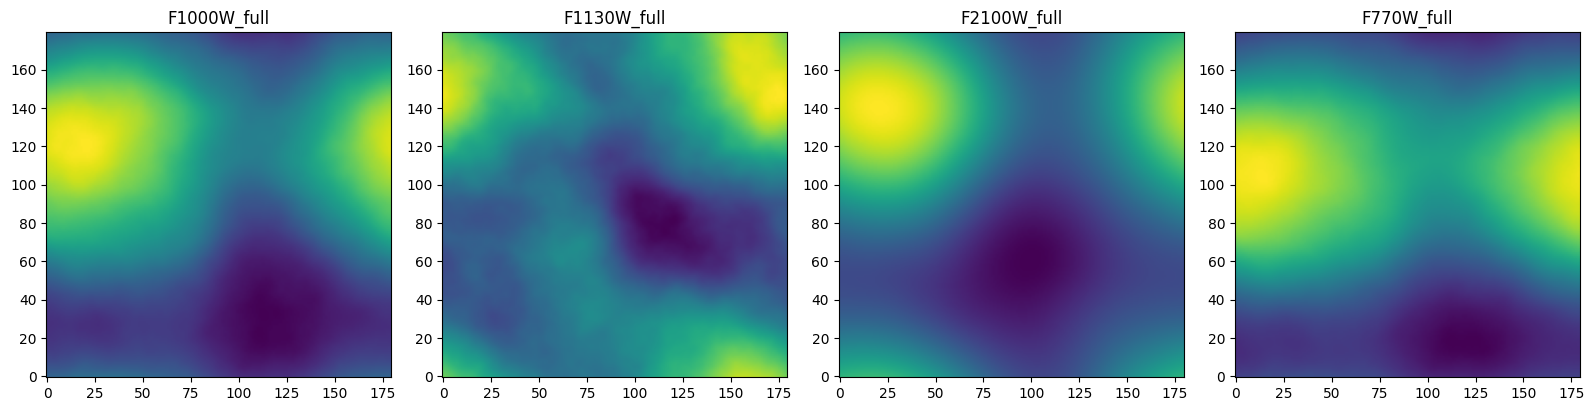

MixtureGP domain keys: ['zeromode', 'fluctuations', 'loglogavgslope', 'spectrum', 'flexibility', 'xi', 'mixture_matrix', 'mixing_offset']


In [12]:
# Imports
from astroprism.models import MixtureGP

# MixtureGP: a multi-channel GP with cross-channel covariance
mixture = MixtureGP(spatial_gps=spatial_gp)

# Draw random sample from MixtureGP prior
key = jax.random.PRNGKey(505)
params = mixture.init(key)
sample = mixture(params)

# Print the sampled GP parameters (first 5 only)
print("Sampled Parameters:")
for name, value in list(params.items())[:5]:
    print(f"{name}: {value}")

# Plot
fig, axes = plt.subplots(1, dataset.n_channels, figsize=(4*dataset.n_channels, 4))
for i in range(dataset.n_channels):
    axes[i].imshow(sample[i], origin='lower', norm=LogNorm())
    axes[i].set_title(dataset.channel_keys[i])
plt.tight_layout()
plt.show()

# Print the domain of the MixtureGP (parameters)
print("MixtureGP domain keys:", list(mixture.domain.keys()))